In [5]:
import numpy as np

import pandas as pd

In [6]:
import pickle
# 
x = open('C:/Users/Forge-15 1650/Desktop/190003/data analytic/final_train_bkp', 'rb')
final_train = pickle.load(x)

#train data
test = final_train[final_train['target'].isnull()] #seperating the test from the final dataset

#train data
train = final_train[final_train['target'].notnull()]
target_cols = ['target', 'ret', 'transactionRevenue_sum', 'fullVisitorId']
# ['target', 'ret', 'transactionRevenue_sum', 'fullVisitorId']
target_test = test['transactionRevenue_sum'].astype('float').apply(lambda x: np.log1p(x))

#target
target_cols = ['target', 'ret', 'transactionRevenue_sum', 'fullVisitorId']
target_test = test['transactionRevenue_sum'].astype('float').apply(lambda x: np.log1p(x))

# train data 
train_x = train.drop(target_cols, axis = 1)
train_x_id = train['fullVisitorId'].astype('str')
train_y = train['target']
train_ret = train['ret']
test_x = test.drop(target_cols, axis = 1)
test_x_id = test['fullVisitorId'].astype('str')
test_y = target_test
test_ret = test['ret']

In [7]:
#correct dtype train
train_x['isMobile'] = train_x['isMobile'].astype('object')
train_x['isTrueDirect'] = train_x['isTrueDirect'].astype('object')

#correct dtype test
test_x['isMobile'] = test_x['isMobile'].astype('object')
test_x['isTrueDirect'] = test_x['isTrueDirect'].astype('object')

#taking cat and numerical columns seperately
cat_cols = [x for x in train_x.columns if train_x[x].dtype == 'object']
num_cols = set(train_x.columns) - set(cat_cols)

print(num_cols)
print('\n')
print(cat_cols)

# fill missing in train
for col in cat_cols:
    train_x[col].fillna('missing', inplace=True) 
    test_x[col].fillna('missing', inplace=True)

for col in num_cols:       
    train_x[col].fillna(0, inplace=True)
    test_x[col].fillna(0, inplace=True)


{'hits_mean', 'sessionQualityDimMax', 'bounces_mean', 'pageviews_mean', 'first_ses_from_the_period_start', 'pageviews_max', 'interval_dates', 'timeOnSite_mean', 'last_ses_from_the_period_end', 'timeOnSite_max', 'sessionQualityDimSum', 'timeOnSite_sum', 'hits_sum', 'hits_min', 'transactions', 'pageviews_min', 'sessionQualityDimMean', 'visitNumber_max', 'timeOnSite_min', 'sessionQualityDimMin', 'pageviews_sum', 'newVisits', 'visitStartTime_counts', 'hits_max'}


['channelGrouping', 'browser', 'operatingSystem', 'isMobile', 'deviceCategory', 'continent', 'subContinent', 'country', 'region', 'metro', 'city', 'networkDomain', 'campaign', 'source', 'medium', 'keyword', 'googleAds', 'referralPath', 'isTrueDirect', 'customDimensions_value']


In [8]:
from sklearn.preprocessing import LabelEncoder
for col in cat_cols:
    print("transform column {}".format(col))
    lbe = LabelEncoder()
    lbe.fit(pd.concat([train_x[col],test_x[col]]).astype("str"))
    train_x[col] = lbe.transform(train_x[col].astype("str"))
    test_x[col] = lbe.transform(test_x[col].astype("str"))
    
#normalization
from sklearn.preprocessing import StandardScaler
for col in num_cols:
    norm = StandardScaler()
    norm.fit(train_x[col].values.reshape(-1,1))
    train_x[col] = norm.transform(train_x[col].values.reshape(-1,1))
    test_x[col] = norm.transform(test_x[col].values.reshape(-1,1))

transform column channelGrouping
transform column browser
transform column operatingSystem
transform column isMobile
transform column deviceCategory
transform column continent
transform column subContinent
transform column country
transform column region
transform column metro
transform column city
transform column networkDomain
transform column campaign
transform column source
transform column medium
transform column keyword
transform column googleAds
transform column referralPath
transform column isTrueDirect
transform column customDimensions_value


## lightgbm

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:502: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


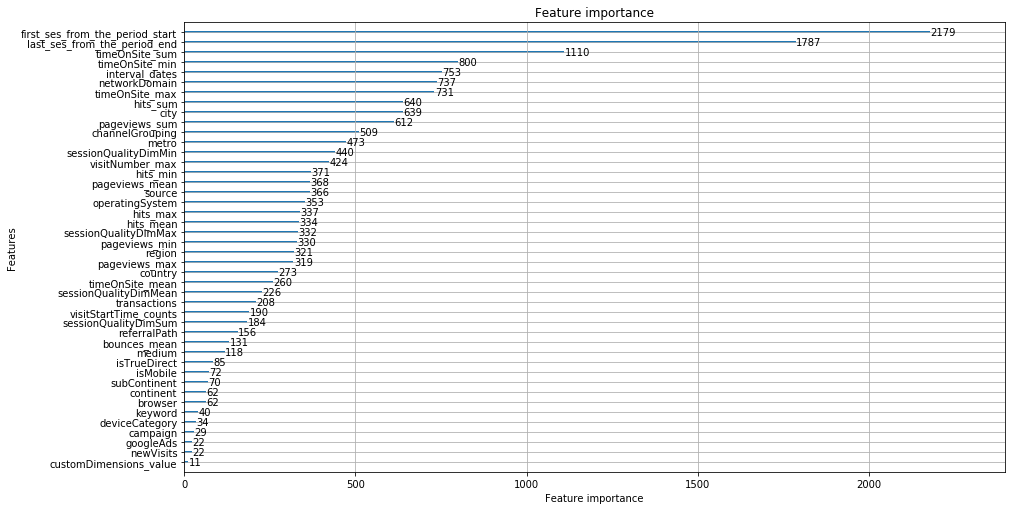

In [12]:
#lets specify thr parametrs first
import lightgbm as lgb
params1 = {'task': 'train',
           'num_iterations': 50, #no of boost round or number of estimators 
           'boosting':'gbdt', #gradient boosted decision tree
           'objective' : 'regression',
           'metric': ['rmse'], #roort mean suqre error
           'is_training_metric': True, #return metric on train data
           'learning_rate' :0.01,
           'max_leaves': 1000,
           'feature_fraction': 0.8, #col sampling
           'bagging_fraction': 0.8, 
           'colsample_bytree': 1.0,
           'max_depth':30, 
           'min_child_samples': 100,
           'reg_alpha': 1, 
           'reg_lambda': 1}

#create train data 
dtrain1 = lgb.Dataset(data = train_x, label = list(train_y.values)) 

#training 
lgb_trainmodel = lgb.train(params1, dtrain1) 
lgb_traincv = lgb.cv(params1, dtrain1, nfold= 5, stratified=False, metrics = 'rmse', eval_train_metric= True)
#predicting

lgbpred_train = lgbmodel.predict(train_x)
lgbpred_test = lgbmodel.predict(test_x)

lgb.plot_importance(lgb_trainmodel, figsize=(14.70, 8.27));

In [36]:

from sklearn.metrics import mean_squared_error
train_mse_lg = mean_squared_error(train_y.values, lgbpred_train)
print('train_rmse_lightgbm',np.sqrt(train_mse_lg))

test_mse_lg = mean_squared_error(test_y.values, lgbpred_test)
print('test_rmse_lightgbm',np.sqrt(test_mse_lg))

x_lg = pd.DataFrame(data ={'fullVisitorId': test['fullVisitorId'].astype('str'), 'PredictedLogRevenue': pred_test})
# x_lg.to_csv('results/submission_0521_lgbm.csv', index = False)

train_rmse_lightgbm 0.30527647906491623
test_rmse_lightgbm 2.1077497475030764


## Catboost

CatBoost, a machine learning algorithm that uses gradient boosting on decision trees.

- Unique feature：<br>
For every tree level, 
Catboost utilizes same features to divide learning samples into left and right partitions. <br>
- Can be tuned into fast and efficient model


#### Prepare training data
Include all features except target columns below: 
- ['target', 'ret', 'transactionRevenue_sum', 'fullVisitorId']

In [10]:
train_x[['channelGrouping', 'first_ses_from_the_period_start', 'last_ses_from_the_period_end', 'interval_dates',
         'visitStartTime_counts', 'visitNumber_max', 'isMobile', 'operatingSystem', 'deviceCategory', 'continent',
         'country', 'region', 'city', 'networkDomain', 'bounces_mean', 'hits_sum', 'hits_min', 'hits_max', 'hits_mean', 
         'pageviews_sum', 'pageviews_min', 'pageviews_max', 'pageviews_mean', 'sessionQualityDimMax', 'sessionQualityDimMean',
         'timeOnSite_max', 'timeOnSite_mean', 'timeOnSite_sum', 'transactions', 'campaign', 'source', 'medium', 'referralPath']]

,channelGrouping,first_ses_from_the_period_start,last_ses_from_the_period_end,interval_dates,visitStartTime_counts,visitNumber_max,isMobile,operatingSystem,deviceCategory,continent,...,sessionQualityDimMax,sessionQualityDimMean,timeOnSite_max,timeOnSite_mean,timeOnSite_sum,transactions,campaign,source,medium,referralPath
0,4,-0.018261,0.219949,-0.185269,-0.207383,-0.165488,0,6,0,4,...,-0.227094,-0.247510,0.163520,0.350777,0.058843,-0.092882,41,110,4,3571
1,4,0.875995,-0.677161,-0.185269,-0.207383,-0.165488,0,21,0,1,...,-0.227094,-0.247510,0.439200,0.736632,0.224314,-0.092882,41,0,3,3571
2,4,-1.326927,1.532793,-0.185269,-0.207383,-0.165488,1,0,1,1,...,-0.227094,-0.247510,0.184932,0.380746,0.071695,-0.092882,41,110,4,3571
3,4,-0.519916,0.723206,-0.185269,-0.207383,-0.165488,0,21,0,1,...,-0.227094,-0.247510,-0.345016,-0.360993,-0.246395,-0.092882,41,0,3,3571
4,7,-1.610472,1.817242,-0.185269,-0.207383,-0.165488,0,6,0,2,...,-0.227094,-0.247510,-0.355722,-0.375978,-0.252821,-0.092882,41,380,5,2900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1344562,2,0.090795,-0.633399,-0.185269,-0.207383,-0.165488,1,0,1,1,...,0.135457,0.271037,0.104637,0.268362,0.023499,-0.092882,41,0,3,3571
1344563,6,1.115917,-1.661794,-0.185269,-0.207383,-0.165488,0,6,0,1,...,8.353278,12.024767,1.424155,2.115218,0.815512,6.367849,41,0,3,3571
1344564,4,-1.370550,0.832609,-0.185269,-0.207383,-0.165488,0,5,0,3,...,-0.106244,-0.074661,-0.355722,-0.375978,-0.252821,-0.092882,41,110,4,3571
1344565,4,-0.236372,-0.305189,-0.185269,-0.207383,-0.165488,0,21,0,1,...,0.014606,0.098188,0.013636,0.140992,-0.031122,-0.092882,41,110,4,3571


## Parameters tuning


1. learning rate: controls how fast a model learns <br>
 - smaller value, higher iterations needed to train Catboost <br>
 - initial learning rates for grid search: [0.03, 0.05, 0.1]; iterations = 1000


2. Tree depth:  <br>
 - larger tree depth, more splits, captures more data information
 
 
3. L2 regularization: ridge regression is chosen
 - prevent overfitting

In [ ]:
grid_search_result

In [ ]:
train_x.columns


### best catboost parameters found from running grid search are fitted to the model

In [11]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return round(np.sqrt(mean_squared_error(y_true, y_pred)), 5)


X_train, X_validation, y_train, y_validation = train_test_split(train_x, 
                                                                train_y, 
                                                                test_size=0.15,     #  train size 85%, test size 15%
                                                                random_state=1)     # fixed train-test splits to be deterministic
# use best parameters from Grid Search results
clf = CatBoostRegressor(iterations = 1000,                      
                        learning_rate = 0.03,
                        random_seed = 2,
                        depth = 8,
                        l2_leaf_reg = 1,
                        eval_metric='RMSE',               # square root of mean-squared error [accuracy test]
                        od_wait = 10)

clf.fit(X_train, y_train,
        eval_set = (X_validation, y_validation),
        use_best_model = True,
        verbose=True)

y_pred_train = clf.predict(X_train)
y_pred_validation = clf.predict(X_validation)
y_pred_test = clf.predict(test_x)

print(f"CatB: RMSE val: {rmse(y_validation, y_pred_validation)}  - RMSE train: {rmse(y_train, y_pred_train)}" , "= {}".format((rmse(y_validation, y_pred_validation)-(rmse(y_train, y_pred_train)))))

x = pd.DataFrame(data ={'fullVisitorId': test['fullVisitorId'].astype('str'), 'PredictedLogRevenue': y_pred_test})
# D:/datasets/results
# x.to_csv('dir/submission_0521_catboost_WithValidationSet.csv', index = False)

0:	learn: 0.3127171	test: 0.2964357	best: 0.2964357 (0)	total: 253ms	remaining: 4m 12s
1:	learn: 0.3122579	test: 0.2963198	best: 0.2963198 (1)	total: 566ms	remaining: 4m 42s
2:	learn: 0.3118144	test: 0.2961903	best: 0.2961903 (2)	total: 724ms	remaining: 4m
3:	learn: 0.3113369	test: 0.2960126	best: 0.2960126 (3)	total: 875ms	remaining: 3m 37s
4:	learn: 0.3109190	test: 0.2959735	best: 0.2959735 (4)	total: 1.04s	remaining: 3m 26s
5:	learn: 0.3104853	test: 0.2959617	best: 0.2959617 (5)	total: 1.19s	remaining: 3m 17s
6:	learn: 0.3100866	test: 0.2958700	best: 0.2958700 (6)	total: 1.32s	remaining: 3m 8s
7:	learn: 0.3097124	test: 0.2958259	best: 0.2958259 (7)	total: 1.5s	remaining: 3m 6s
8:	learn: 0.3093678	test: 0.2958229	best: 0.2958229 (8)	total: 1.78s	remaining: 3m 16s
9:	learn: 0.3089611	test: 0.2957122	best: 0.2957122 (9)	total: 2.04s	remaining: 3m 21s
10:	learn: 0.3086486	test: 0.2955362	best: 0.2955362 (10)	total: 2.19s	remaining: 3m 17s
11:	learn: 0.3083570	test: 0.2955229	best: 0.295

### from results above, best RMSE is 0.290167 at 147th iteration

- model is hence shrinked to first 148 iterations
- difference in RMSE value between validation and training sets is 0.00043.

## Comparison on Model Performances
- R-squared determination coefficient (r2_score) <br>
When R-squared scores is higher, differences between observed data and the fitted values is smaller. <br>
> = better fit of model to observed data.

- Root mean-squared error (RMSE) <br>
measures how spread out the datas around best fit line. <br>
> lower RMSE = higher accuracy

In [53]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.metrics import r2_score

train_mse_lg = mean_squared_error(train_y.values, lgbpred_train)
train_rmse_lg = np.sqrt(train_mse_lg)
test_mse_lg = mean_squared_error(test_y.values, lgbpred_test)
test_rmse_lg = np.sqrt(test_mse_lg)
#train set r2 score
r2_tr_lg = metrics.r2_score(train_y, lgbpred_train)
gb_r2__cb = metrics.r2_score(y_train, y_pred_train)
print()

#train set rmse score
cat_RMSE_val = rmse(y_validation, y_pred_validation)
cat_RMSE_test = rmse(test_y, y_pred_test)
cat_RMSE_train = rmse(y_train, y_pred_train)

print("Lightgbm r2 score : {}".format(r2_tr_lg))
print("catboost r2 score : {}".format(gb_r2__cb))


Lightgbm r2 score : 0.03541863773019327
catboost r2 score : 0.16502251321043926


In [48]:

print("Lightgbm mean train rmse_score of {}".format(test_rmse_lg))
print("catboost mean train rmse_score of {}".format(cat_RMSE_train))

Lightgbm mean train rmse_score of 0.30527647906491623
catboost mean train rmse_score of 0.28622


In [55]:
print("Lightgbm mean test rmse_score of {}".format(test_rmse_lg))
print("catboost mean validation rmse_score of {}".format(cat_RMSE_test))

Lightgbm mean test rmse_score of 2.1077497475030764
catboost mean validation rmse_score of 2.09911


## conclusion [comparison between models]

1. Higher r2 score of Catboost compared to Lightgbm implies better better fit of model to real data points.

2. Lower RMSE values of Catboost in train and test set compared to Lightgbm implies better fit of observed data points to model's predicted values.

> Kaggle accuracy score of Catboost is better than Lightgbm. <br>
> We can conclude that our Catboost model performed better than Lightgbm in this case.
